# 该文档主要讲解如何导入10X空转数据, 我们这里以DLPFC数据集为例

### 首先，导入必要的Python包

In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os

### 10X Visium的计数矩阵数据一般以 "_filtered_feature_bc_matrix.h5"为后缀结尾; 我们参考scanpy封装好的sc.read_visium()的源码进行讲解

In [2]:
# 设定文件夹路径
path = 'D:/st_projects/data/DLPFC'
# 设定切片ID，比如我要读取DLPFC的151673切片数据
section = '151673'
# 路径拼接
spatial_path = os.path.join(path, section)
count_file = '151673_filtered_feature_bc_matrix.h5'

adata = sc.read_10x_h5(os.path.join(spatial_path, count_file))
display(adata)

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3639 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

### 可以看到，这里我们已经读入了计数矩阵。但是，该计数矩阵是包含 $spots \times genes$的计数矩阵，没有空间信息，以及形态学信息。我们现在将位置信息与形态学信息读取进来

In [3]:
# 在10X Visium数据集中，位置信息一般存放在spatial文件夹中
position_data = pd.read_csv(os.path.join(spatial_path, 'spatial') + '/tissue_positions_list.csv', header=None)
display(position_data)

# 为读取进来的表格设置列名称, 以及索引
position_data.columns = ['barcode', 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres']
position_data.index = position_data['barcode']
display(position_data)

# 将读取的位置信息存储在adata对象中。注意，我们这里将adata.obsm['spatial']中存储的位置信息，设定为全尺寸H&E染色图像中，每个Spot对应的像素位置
adata.obs = adata.obs.join(position_data, how="left")
adata.obsm['spatial'] = adata.obs[['pxl_row_in_fullres', 'pxl_col_in_fullres']].to_numpy()
adata.obs.drop(columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'], inplace=True)
display(adata)

,0,1,2,3,4,5
0,ACGCCTGACACGCGCT-1,0,0,0,2427,2811
1,TACCGATCCAACACTT-1,0,1,1,2547,2879
2,ATTAAAGCGGACGAGC-1,0,0,2,2428,2949
3,GATAAGGGACGATTAG-1,0,1,3,2548,3017
4,GTGCAAATCACCAATA-1,0,0,4,2429,3086
...,...,...,...,...,...,...
4987,GAACGTTTGTATCCAC-1,0,77,123,11713,11214
4988,ATTGAATTCCCTGTAG-1,0,76,124,11594,11283
4989,TACCTCACCAATTGTA-1,0,77,125,11714,11351
4990,AGTCGAATTAGCGTAA-1,0,76,126,11595,11421


,barcode,in_tissue,array_row,array_col,pxl_col_in_fullres,pxl_row_in_fullres
barcode,,,,,,
ACGCCTGACACGCGCT-1,ACGCCTGACACGCGCT-1,0,0,0,2427,2811
TACCGATCCAACACTT-1,TACCGATCCAACACTT-1,0,1,1,2547,2879
ATTAAAGCGGACGAGC-1,ATTAAAGCGGACGAGC-1,0,0,2,2428,2949
GATAAGGGACGATTAG-1,GATAAGGGACGATTAG-1,0,1,3,2548,3017
GTGCAAATCACCAATA-1,GTGCAAATCACCAATA-1,0,0,4,2429,3086
...,...,...,...,...,...,...
GAACGTTTGTATCCAC-1,GAACGTTTGTATCCAC-1,0,77,123,11713,11214
ATTGAATTCCCTGTAG-1,ATTGAATTCCCTGTAG-1,0,76,124,11594,11283
TACCTCACCAATTGTA-1,TACCTCACCAATTGTA-1,0,77,125,11714,11351


AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

### 直接根据adata.obsm['spatial']中存储的位置信息，进行绘图

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


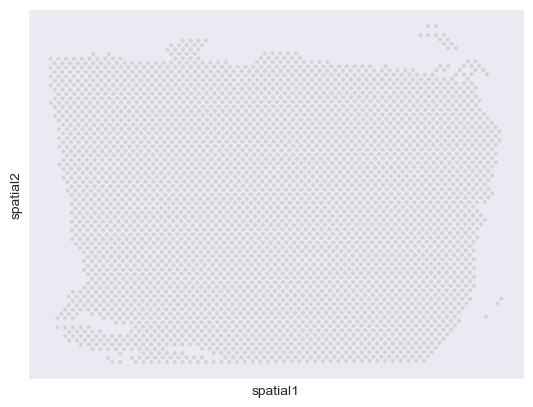

In [4]:
sc.pl.embedding(adata, basis='spatial')

### 现在，我们导入图像信息

In [5]:
from pathlib import Path
from h5py import File

# 根据.h5 file中存储的信息，为adata对象设定library_id
with File(spatial_path + '/' + count_file, mode="r") as f:
    attrs = dict(f.attrs)
display(attrs)
library_id = str(attrs.pop("library_ids")[0], "utf-8")

adata.uns["spatial"] = dict()
adata.uns["spatial"][library_id] = dict()
adata.uns["spatial"][library_id]['images'] = dict()
# 一般而言，我们下载到的10X Visium数据集的spatial文件夹中，会附带一个高分辨率与低分辨率的染色图像。全尺寸H&E染色图像需要额外单独下载
# 我们这里演示将高分辨率与低分辨率图像读取并导入adata对象的过程
spatial_path = Path(spatial_path)
files = dict(
    scalefactors_json_file=spatial_path / 'spatial/scalefactors_json.json',
    hires_image=spatial_path / 'spatial/tissue_hires_image.png',
    lowres_image=spatial_path / 'spatial/tissue_lowres_image.png',
)

for res in ['hires', 'lowres']:
    adata.uns["spatial"][library_id]['images'][res] = plt.imread(str(files[f'{res}_image']))

{'chemistry_description': 'custom',
 'filetype': 'matrix',
 'library_ids': array([b'151673'], dtype='|S6'),
 'original_gem_groups': array([1], dtype=int64),
 'software_version': '4509.5.5',
 'version': 2}

### 验证读取到的图像是否正确

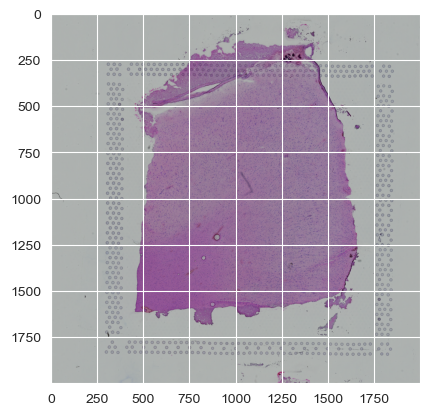

In [6]:
plt.imshow(adata.uns['spatial'][library_id]['images']['hires'])

### 然而，正如我们之前所说的，空间上的位置信息是根据全尺寸的图像信息来的，我们需要映射系数，将全尺寸的位置信息转换到低分辨率的位置信息，以配合图像进行可视化，或者根据转换后的位置信息找对应的Spot，提取形态学特征

In [7]:
import json
# 一般而言，10X Visium的映射信息存储在以.json为后缀的文件中
adata.uns["spatial"][library_id]['scalefactors'] = json.loads(files['scalefactors_json_file'].read_bytes())

adata.uns["spatial"][library_id]["metadata"] = {
    k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
    for k in ("chemistry_description", "software_version") if k in attrs
}

### 现在，我们对数据进行可视化验证。我们使用'log1p_total_counts'来进行

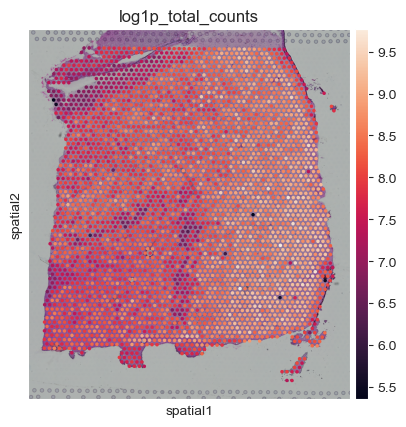

In [8]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
# 可以看到，spots的空间位置信息与实际的图像是吻合的，证明读取正确
sc.pl.spatial(adata, color='log1p_total_counts', size=1)

### 接下来，我们目前所看到的所有算法，都是基于该adata对象进行的。我们这里以最简单的non-spatial clustering算法为例，即scanpy自带的leiden/louvain算法为例

In [9]:
# 首先，对读取进来的数据进行预处理，包括筛掉不表达的genes、仅保留总表达量>100的genes等步骤
adata = adata[:, adata.var['total_counts'] > 100]
sc.pp.filter_genes(adata, min_cells=1)
# 对计数矩阵进行标准化，使得每个细胞的总基因表达量类似，以便进行后续的，包括相似性计算等下游任务
sc.pp.normalize_total(adata, target_sum=1e4)
# 对计数矩阵进行对数转换，防止某个gene的表达值过大
sc.pp.log1p(adata)
# 部分论文里，这里还会执行scale操作，该操作会使每个spot的数据分布为0均值、1方差
sc.pp.scale(adata)

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### 我们随机选取adata中的5个spot的gene表达分布，并可视化，来验证数据的预处理

array([2386, 2118, 1708, 1649, 2340])

C:\Users\wangyu\AppData\Local\Temp\ipykernel_14752\1826160160.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.X[i])
C:\Users\wangyu\AppData\Local\Temp\ipykernel_14752\1826160160.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.X[i])
C:\Users\wangyu\AppData\Local\Temp\ipykernel

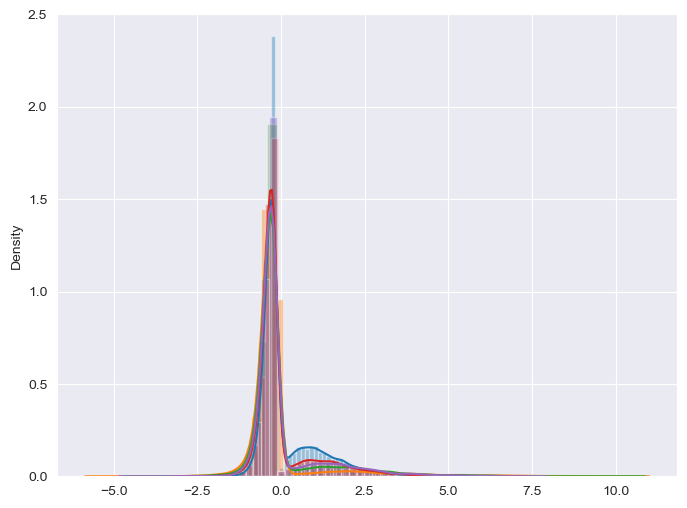

In [14]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))
spot_indexes = np.random.choice(adata.shape[0], 5, replace=False)
display(spot_indexes)
for i in range(len(spot_indexes)):
    sns.distplot(adata.X[i])

In [17]:
# 对数据进行降维
sc.pp.pca(adata, n_comps=100)
# 在降维后的数据上构建KNN图
sc.pp.neighbors(adata, n_neighbors=15)
# 在KNN图上执行图聚类算法，可选louvain或leiden
sc.tl.louvain(adata, resolution=1)
sc.tl.leiden(adata, resolution=1)

### 根据设定的聚类分辨率，会产生不同的簇数(number of spatial domains)

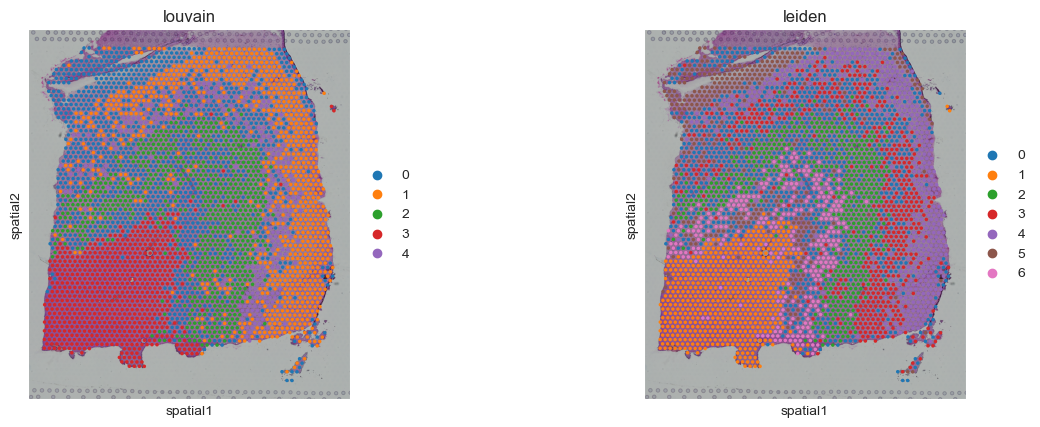

In [18]:
sc.pl.spatial(adata, color=['louvain', 'leiden'], size=1)